## Install necessary libraries

In [1]:
! pip install -U transformers
! pip install datasets evaluate -q
! pip install jiwer -q
! pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.4 MB/s eta 0:00:00


In [2]:
## Generates Token
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import transformers, accelerate

print(accelerate.__version__)
print(transformers.__version__)

0.24.1
4.35.2


## 1. Image2Text Models/API

Let's look at some Image2Text models/API
Reference: https://huggingface.co/docs/transformers/v4.27.0/tasks/image_captioning

In [2]:
# Image Captioning

from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch

device = "cuda" if torch.cuda.is_available() else "cpu" # Set device to GPU if its available

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint) # We would load a tokenizer for language. Here we load a processor to process images

model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)


### 1b. Sample Image

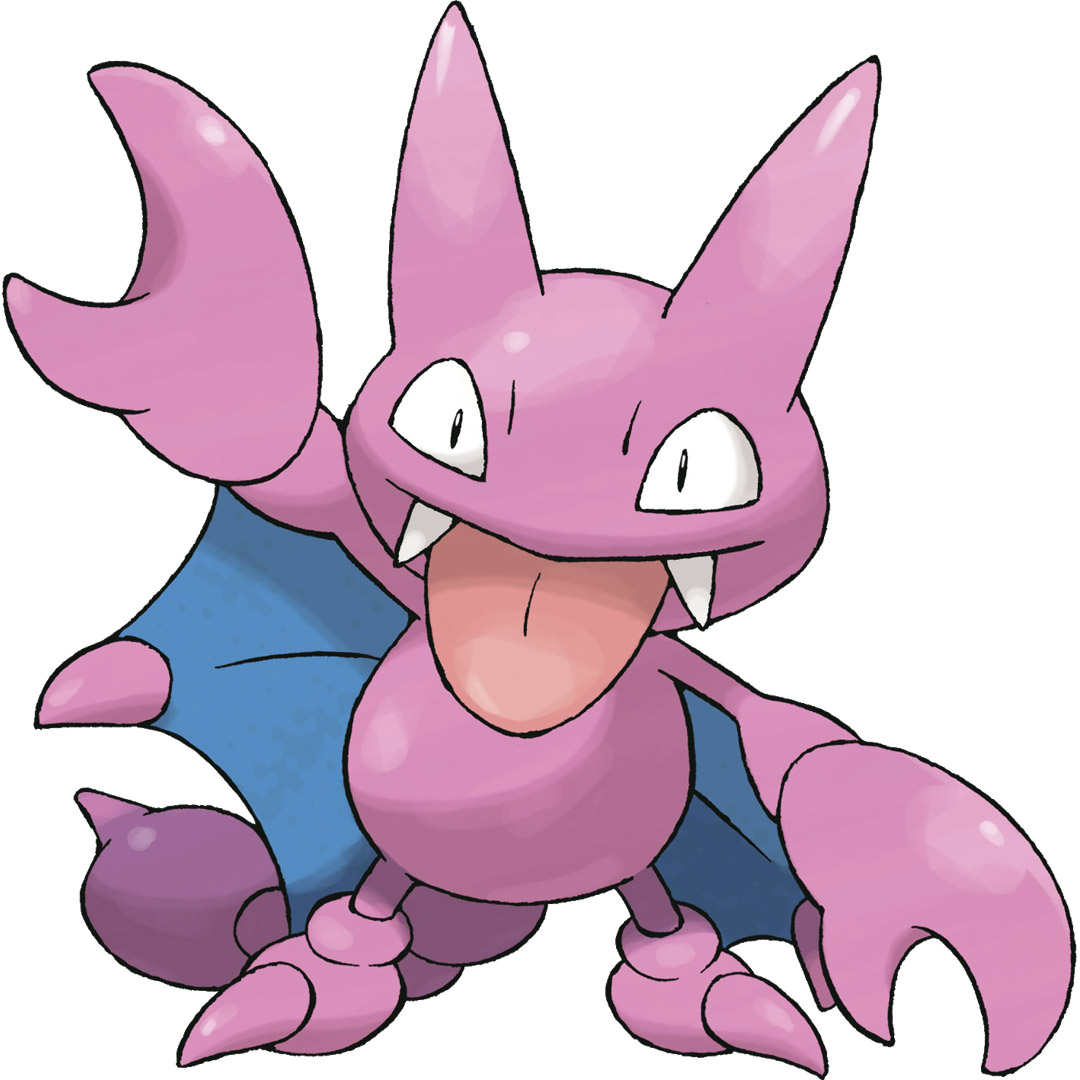

In [6]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

### 1c. Process the image

In [188]:
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values.to(device)

#print(inputs.shape)
print(pixel_values.shape)
#image = requests.get(url, stream=True)
print(inputs.keys())
print(inputs)

torch.Size([1, 3, 640, 864])
dict_keys(['pixel_values', 'pixel_mask'])
{'pixel_values': tensor([[[[-0.6452, -0.6623, -0.6623,  ..., -0.7822, -0.7822, -0.7822],
          [-0.6452, -0.6623, -0.6623,  ..., -0.7822, -0.7822, -0.7822],
          [-0.6452, -0.6623, -0.6623,  ..., -0.7822, -0.7822, -0.7822],
          ...,
          [-0.5424, -0.5253, -0.5082,  ..., -0.1314, -0.1314, -0.1143],
          [-0.5082, -0.4911, -0.5082,  ..., -0.0972, -0.0972, -0.0801],
          [-0.5082, -0.5082, -0.5253,  ..., -0.0972, -0.0972, -0.0801]],

         [[ 0.3803,  0.3627,  0.3627,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.3803,  0.3627,  0.3627,  ...,  0.2227,  0.2227,  0.2227],
          [ 0.3803,  0.3627,  0.3627,  ...,  0.2227,  0.2227,  0.2227],
          ...,
          [-0.3200, -0.2850, -0.2850,  ..., -0.0574, -0.0574, -0.0399],
          [-0.2850, -0.2675, -0.2850,  ..., -0.0224, -0.0224, -0.0049],
          [-0.2850, -0.2850, -0.3025,  ..., -0.0224, -0.0224, -0.0049]],

         [[ 1.

### 1d. Let's do direct inference from the pre-trained model

In [7]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

how to draw a character step by step


### 1e. Load Fine-Tuning Data (Need to fine-tune for our images)

Now we see that the caption provided earlier from the pre-trained model is too generic (referring to a drwaing rather than what exactly the drawing is about!).
This is why we need to fine-tune even large foundation models for specific use-cases

In [8]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

### 1f. Split Data into Train and Test (Essence of ML Training)

In [9]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

### 1g. Data Visualization

In [10]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

### 1h. Process the Data (Tokenization)

In [11]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms) # Set the train data to use this particular transformation
test_ds.set_transform(transforms) # Set test data to use this particular transformation

### 1i. Add Evaluation Metrics

In [12]:
from evaluate import load

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

### 1j. Set Training Arguments for fine-tuning the pre-trained model

In [17]:
# NOTE: For this to work, you have to set your Runtime type to GPU

from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=8,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

# Initialize the trainer - Note it takes a model, training args, data set and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

### 1k. Train the model

In [18]:
# If you run in to out of memory issues:
# a. Reload your GPU runtime
# b. Reduce batch size for training/testing, etc

# c. If this doesn't work - Go back to CPU or take subscription for the more powerful A100 GPU
trainer.train()

TrainOutput(global_step=96, training_loss=2.7505949338277182, metrics={'train_runtime': 231.7801, 'train_samples_per_second': 25.852, 'train_steps_per_second': 0.414, 'total_flos': 2802354365841408.0, 'train_loss': 2.7505949338277182, 'epoch': 8.0})

### 1l. Inference with the fine-tuned model

In [23]:
# The pokemon image was loaded previously, so we skip that step - We just regenerate the model predictions for the model that has been fine-tuned
import time
t1 = time.time()
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
print(str(time.time() - t1) + " seconds")

a pink and blue pokemon character with a big smile
0.30330777168273926 seconds


### 1m. Save the model for future inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

import os
print(os.system('ls'))

os.chdir(os.curdir + "/drive/MyDrive/Colab_Notebooks_LLM_2023")

PATH="image_caption_finetuned_model"
torch.save(model.state_dict(), PATH) # This is now saving model to path in your favorite directory on google drive

# Let's check the size of the model!!!

### 1n. Load saved model

In [15]:
import time

t1 = time.time()
PATH="image_caption_finetuned_model"
model_finetuned = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
model_finetuned.load_state_dict(torch.load(PATH))
print("Time to load model = " + str(time.time() - t1) + " seconds")

Time to load model = 2.472379684448242 seconds


### 1o. Let's evaluate on the pokemon image again

In [18]:
t1 = time.time()
generated_ids = model_finetuned.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)
print("Inference time on pokemon image = " + str(time.time() - t1) + " seconds")

a pink and blue cartoon character with big eyes
Inference time on pokemon image = 0.19155454635620117 seconds


## 2. Text2Image Stable Diffusion Models

In [19]:
!! pip install --upgrade diffusers transformers scipy

['Collecting diffusers',
 '  Downloading diffusers-0.23.1-py3-none-any.whl (1.7 MB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.7 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.1/1.7 MB\x1b \x1b3.9 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.7/1.7 MB\x1b \x1b27.1 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hRequirement already satisfied: transformers in /usr/local/lib/python3.10/dist-packages (4.35.2)',
 'Requirement already satisfied: scipy in /usr/local/lib/python3.10/dist-packages (1.11.3)',
 'Requirement already satisfied: Pillow in /usr/local/lib/python3.10/dist-packages (from diffusers) (9.4.0)',
 'Requirement already satisfied: filelock in /usr/local/lib/python3.10/dist-packages (from diffusers) (3.13.1)',
 'Requirement already satisfied: huggingface-hub>=0.13.2 in /usr/local/lib/python3.10/dist-packages (from diffuser

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

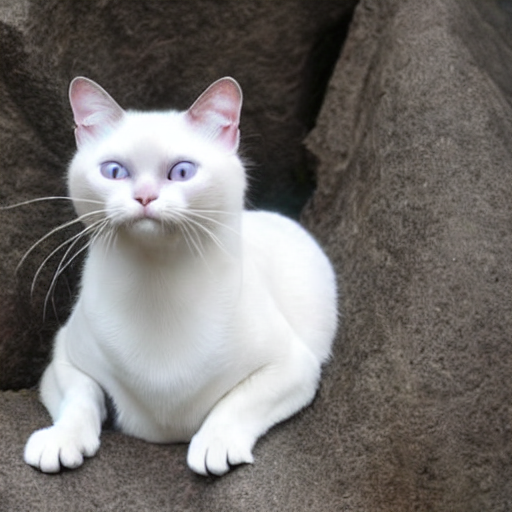

Model Loading + Inference time = 6.257518768310547 seconds


In [27]:
import torch
from diffusers import StableDiffusionPipeline

t1 = time.time()
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "a white siamese cat"
image = pipe(prompt).images[0]

image.save("white_siamese_cat.png")

# Display image
display(image)

print("Model Loading + Inference time = " + str(time.time() - t1) + " seconds")

### 2b. Inference Time

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

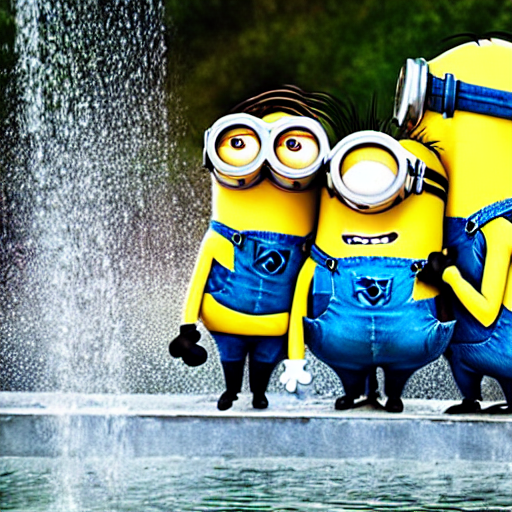

Inference time = 5.164356708526611 seconds


In [29]:
import time

t1 = time.time()
prompt = "Minions having fun with water!"
#prompt = "jasmine"
#prompt = "rafflesia"

# Get response from loaded model
pipe(prompt)
image_2 = pipe(prompt).images[0]
display(image_2)

print("Inference time = " + str(time.time() - t1) + " seconds")

## 3. Image Segmentation

Reference: https://huggingface.co/facebook/maskformer-swin-large-ade

Inference Reference: https://huggingface.co/blog/mask2former

In [31]:
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-large-ade")
inputs = processor(images=image, return_tensors="pt")

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade")
outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:417: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/851M [00:00<?, ?B/s]

In [32]:
predicted_semantic_map

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [9, 9, 9,  ..., 6, 6, 6],
        [9, 9, 9,  ..., 6, 6, 6],
        [9, 9, 9,  ..., 6, 6, 6]])

In [33]:
predicted_semantic_map.shape

torch.Size([512, 683])

In [37]:
print(inputs["pixel_values"].shape)

torch.Size([1, 3, 640, 864])


In [39]:
import numpy as np
np.unique(predicted_semantic_map)

array([ 0,  1,  2,  4,  6,  9, 17])

### 3.1 Inference

In [64]:
#from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
#url = "https://huggingface.co/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000002.jpg"
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade")

processor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-large-ade")
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

predicted_map = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(predicted_map.keys())

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:417: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(
`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


In [65]:
predicted_map

{'segmentation': tensor([[5, 5, 5,  ..., 5, 5, 5],
         [5, 5, 5,  ..., 5, 5, 5],
         [5, 5, 5,  ..., 5, 5, 5],
         ...,
         [2, 2, 2,  ..., 3, 3, 3],
         [2, 2, 2,  ..., 3, 3, 3],
         [2, 2, 2,  ..., 3, 3, 3]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 1,
   'was_fused': False,
   'score': 0.961629},
  {'id': 2, 'label_id': 9, 'was_fused': False, 'score': 0.999903},
  {'id': 3, 'label_id': 6, 'was_fused': False, 'score': 0.997487},
  {'id': 4, 'label_id': 4, 'was_fused': False, 'score': 0.999669},
  {'id': 5, 'label_id': 2, 'was_fused': False, 'score': 0.999967},
  {'id': 6, 'label_id': 0, 'was_fused': False, 'score': 0.985874}]}

### 3.2 Visualization

<ipython-input-67-6732b9cb40e9>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


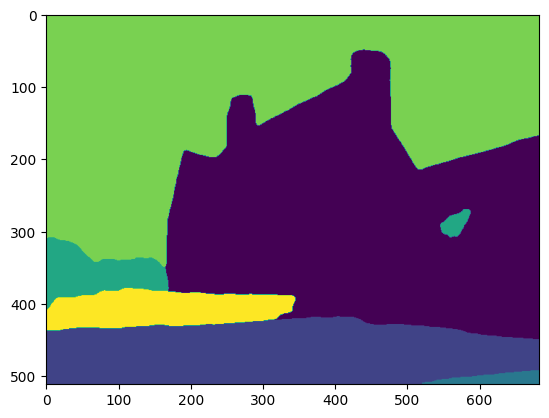

In [67]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    #ax.legend(handles=handles)

draw_panoptic_segmentation(**predicted_map)
display(image)

## 4. Image Embeddings and Image Search

We have looked at word search, keyword search, sentence search, etc in the context of text. This is done by finding word or sentence embedding and then computing cosine similarity, followed by filtering to the top-k results through sorting the scores.

Similarly, we can also compute image embeddings and do image search through pre-trained Foundation models or fine-tuned models.

Hugging Face Reference: https://huggingface.co/blog/image-similarity

More extensive: https://github.com/huggingface/notebooks/blob/main/examples/image_similarity.ipynb

Loading images in Hugging Face: https://huggingface.co/docs/datasets/image_load

### 4.1 Pick an image data set

In [71]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

import os
print(os.system('ls'))

os.chdir(os.curdir + "/drive/MyDrive/Colab_Notebooks_LLM_2023")

Mounted at /content/drive/
0


In [ ]:
!unzip flowers_kaggle.zip

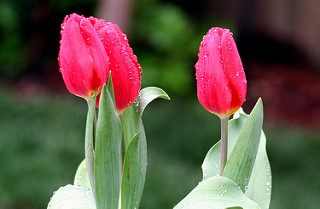

In [107]:
display(Image.open("./flowers/tulip/100930342_92e8746431_n.jpg"))

In [115]:
from datasets import Dataset, Image
import os

def get_paths_to_images(images_directory):

  paths = []
  for file in os.listdir(images_directory):
    paths.append(file)

  return paths

def load_dataset(images_directory):

  paths_images = get_paths_to_images(images_directory)
  print(paths_images[0])
  dataset = Dataset.from_dict({"image": paths_images})

  return dataset

path_images = "./flowers/tulip/"
dataset = load_dataset(path_images)




100930342_92e8746431_n.jpg


### 4.2 Visualize an image from the dataset

{'image': '10094729603_eeca3f2cb6.jpg'}


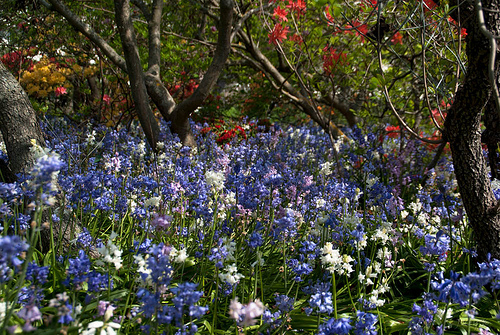

In [108]:
from PIL import Image
print(dataset[1])
display(Image.open(path_images + dataset[1]["image"]))

### 4.3 Split data into train and test

---



In [118]:
dataset_training = dataset.train_test_split(test_size=0.2)
type(dataset_training)

datasets.dataset_dict.DatasetDict

In [119]:
dataset_training

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 787
    })
    test: Dataset({
        features: ['image'],
        num_rows: 197
    })
})

In [122]:
dataset_training["train"][0]
dataset_training["train"].features

{'image': Value(dtype='string', id=None)}

### 4.4 Select 100 random images from the dataset for similarity search

In [144]:

num_samples = 100
seed = 42
candidate_subset = dataset_training["train"].shuffle(seed=seed).select(range(num_samples))
candidate_subset

Dataset({
    features: ['image'],
    num_rows: 100
})

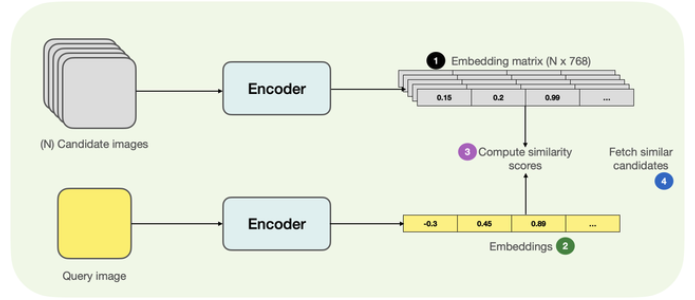

In [149]:
from PIL import Image
Image.open("image_search.png")
#print(type(x))

### 4.5 Load Base Model for Image Embeddings

Here, we will use a Visual Transformer as a base model

In [129]:
from transformers import AutoFeatureExtractor, AutoModel

#model_ckpt = "nateraw/vit-base-beans"
model_ckpt = "jafdxc/vit-base-patch16-224-finetuned-flower"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/839 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at jafdxc/vit-base-patch16-224-finetuned-flower and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [153]:
import torchvision.transforms as T
import torch
from PIL import Image


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)





def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(Image.open("./flowers/tulip/" + image)) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [155]:
all_candidate_embeddings.shape[0]

100

### 4.6 Compute Similarity Scores

In [163]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip([str(index) for index in range(all_candidate_embeddings.shape[0])], sim_scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    #labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids


7


### 4.7 Fetch and Plot 5 nearest flowers to an input flower

140


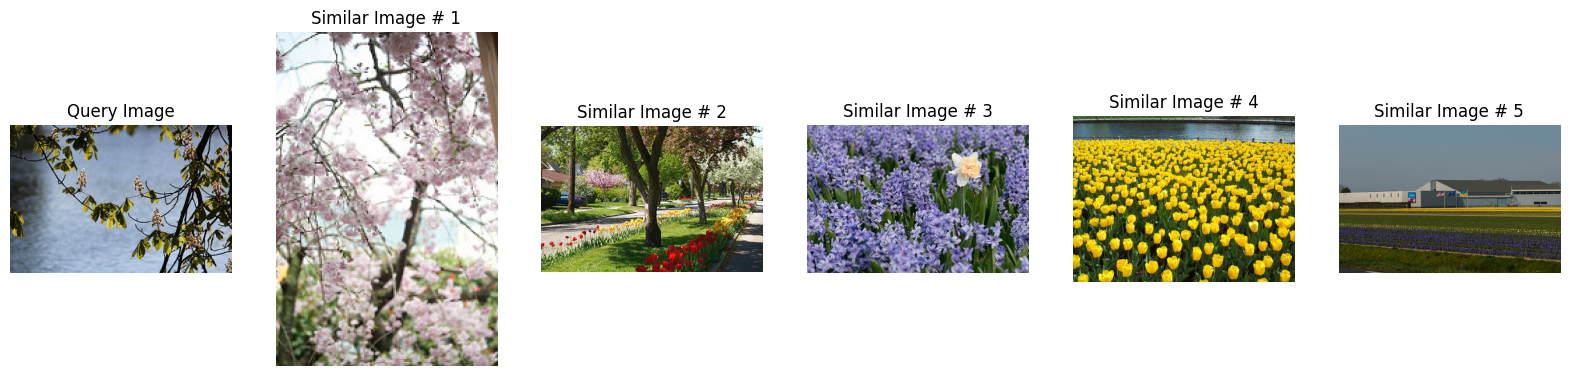

In [174]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image")
        else:
            ax.set_title(
                "Similar Image # " + str(i)
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []

# Generate a random query image
#test_idx = np.random.choice(len(dataset_training["test"]))
test_idx = 140
print(test_idx)
test_sample = Image.open("./flowers/tulip/" + dataset_training["test"][test_idx]["image"])

sim_ids = fetch_similar(test_sample)

# Generate 5 similar images using cosine similarity search
for id in sim_ids:
    images.append(Image.open("./flowers/tulip/" + candidate_subset_emb[id]["image"]))

images.insert(0, test_sample)
plot_images(images)

100


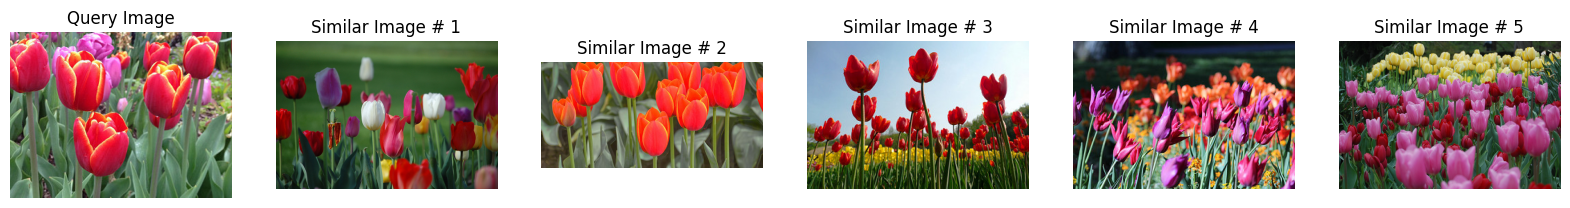

In [180]:
test_idx = 100
print(test_idx)
test_sample = Image.open("./flowers/tulip/" + dataset_training["test"][test_idx]["image"])

sim_ids = fetch_similar(test_sample)

images = []
# Generate 5 similar images using cosine similarity search
for id in sim_ids:
    images.append(Image.open("./flowers/tulip/" + candidate_subset_emb[id]["image"]))

images.insert(0, test_sample)
plot_images(images)

In [181]:
test_idx = 5
print(test_idx)
test_sample = Image.open("./flowers/tulip/" + dataset_training["test"][test_idx]["image"])

sim_ids = fetch_similar(test_sample)

images = []
# Generate 5 similar images using cosine similarity search
for id in sim_ids:
    images.append(Image.open("./flowers/tulip/" + candidate_subset_emb[id]["image"]))

images.insert(0, test_sample)
plot_images(images)

5


17


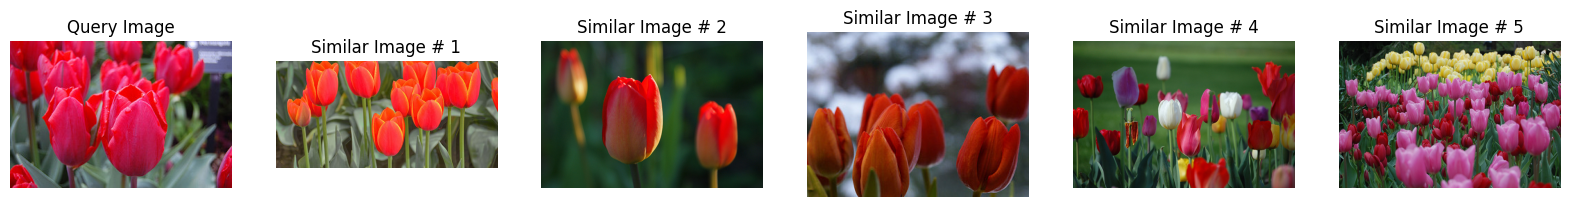

In [185]:
test_idx = 17
print(test_idx)
test_sample = Image.open("./flowers/tulip/" + dataset_training["test"][test_idx]["image"])

sim_ids = fetch_similar(test_sample)

images = []
# Generate 5 similar images using cosine similarity search
for id in sim_ids:
    images.append(Image.open("./flowers/tulip/" + candidate_subset_emb[id]["image"]))

images.insert(0, test_sample)
plot_images(images)